In [33]:
from OF_trigger import *
from trace_IO import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

sampling_frequency = 3906250
template = np.load("../templates/template_K_alpha_no_baseline.npy")
noise_psd = np.load("../templates/noise_psd_from_MMC.npy")
trace_path = "/ceph/dwong/trigger_samples/traces_energy_0.zst"

# Initialize Optimum Filter
trigger = OFtrigger(template, noise_psd, sampling_frequency)

In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm

# Parameters
n_sets = 1000
sigma = 0.7674  # known sigma from MMC noise traces
thresholds = [round(n * sigma, 4) for n in [3, 4, 5]]
sigma_labels = {
    thresholds[0]: '3σ',
    thresholds[1]: '4σ',
    thresholds[2]: '5σ'
}

# Load 0 eV traces
trace_path = "/ceph/dwong/trigger_samples/traces_energy_0.zst"
loaded_traces = load_traces_from_zstd(trace_path, n_traces=n_sets)

# Prepare storage
results = []

for set_idx in tqdm(range(n_sets), desc="Processing 0 eV traces"):
    for trace_idx, trace in enumerate(loaded_traces[set_idx]):
        amplitude, chi2, t0 = trigger.fit_with_shift(trace)
        results.append({
            'set_index': set_idx,
            'trace_index': trace_idx,
            'amplitude': amplitude,
            'chi2': chi2,
            't0': t0
        })

# Convert to DataFrame
df = pd.DataFrame(results)

# Save to CSV
df.to_csv("of_results_noise_0ev.csv", index=False)

# Optional: print basic stats
print("Saved results to 'of_results_noise_0ev.csv'")
print(df.describe())


Processing 0 eV traces: 100%|██████████| 1000/1000 [01:30<00:00, 11.00it/s]


Saved results to 'of_results_noise_0ev.csv'
          set_index   trace_index     amplitude          chi2            t0
count  54000.000000  54000.000000  54000.000000  54000.000000  54000.000000
mean     499.500000     26.500000     -0.007762      0.217602     28.256148
std      288.677663     15.585928      2.264348      0.000228   9432.667029
min        0.000000      0.000000     -3.646435      0.216694 -16384.000000
25%      249.750000     13.000000     -2.220469      0.217448  -8110.250000
50%      499.500000     26.500000     -1.766071      0.217601     59.500000
75%      749.250000     40.000000      2.218605      0.217756   8145.000000
max      999.000000     53.000000      3.630392      0.218677  16383.000000


In [4]:
import pandas as pd

# Read CSV
df = pd.read_csv("of_results_noise_0ev.csv")

# Convert to NumPy array
data_array = df.to_numpy()

print(data_array.shape)  # Should be (54000, 5)


(54000, 5)


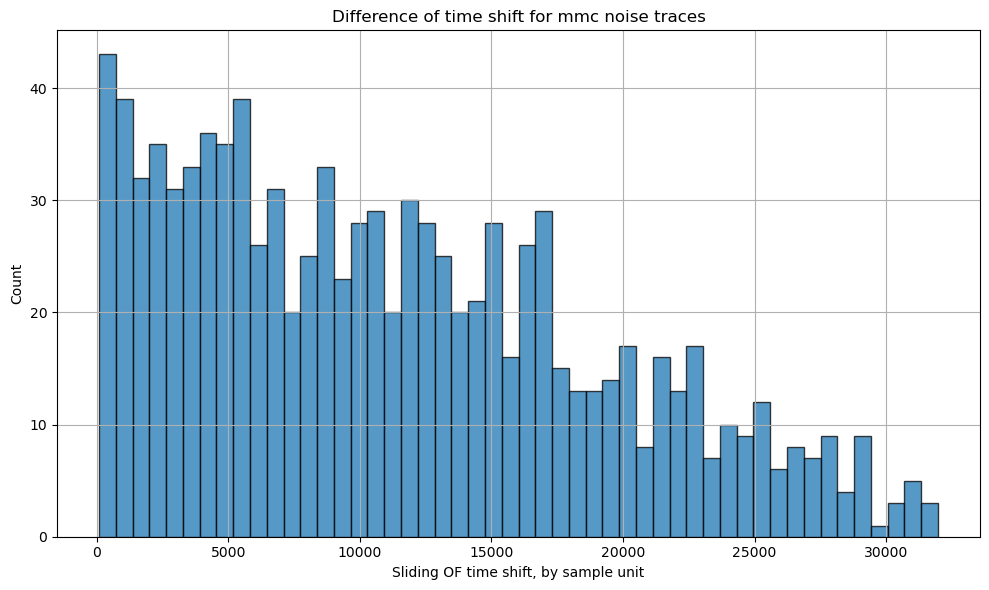

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load CSV (assuming you have the original format)
df = pd.read_csv("of_results_noise_0ev.csv")

# Prepare array to store time shift differences
n_sets = 1000
n_traces_per_set = 54
time_shift_differences = []

# Process each set
for set_idx in range(n_sets):
    # Extract traces for this set
    set_df = df[df["set_index"] == set_idx]
    
    # Sort by amplitude in descending order
    top2 = set_df.sort_values(by="amplitude", ascending=False).iloc[:2]
    
    # Compute absolute time shift difference between top two amplitudes
    t0_diff = abs(top2.iloc[0]["t0"] - top2.iloc[1]["t0"])
    time_shift_differences.append(t0_diff)

time_shift_differences = np.array(time_shift_differences)

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(time_shift_differences, bins=50, edgecolor='black', alpha=0.75)
plt.xlabel('Sliding OF time shift, by sample unit')
plt.ylabel('Count')
plt.title('Difference of time shift for mmc noise traces')
plt.grid(True)
plt.tight_layout()
plt.show()


Processing energies:   0%|          | 0/30 [00:00<?, ?it/s]

Processing energies: 100%|██████████| 30/30 [03:37<00:00,  7.25s/it]


Saved all histograms to 'time_shift_diff_distributions.pdf'


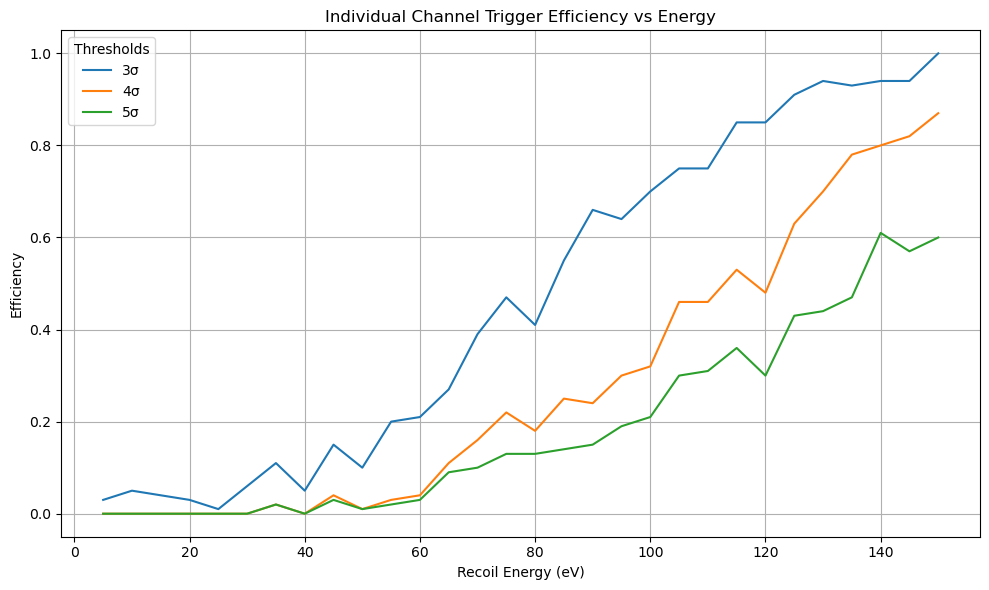

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm

# Parameters
n_sets = 100
sigma = 0.7674  # sigma for the fixed OF ampl distribution with MMC noise traces
thresholds = [round(n * sigma, 4) for n in [3, 4, 5]]
energy_values = list(range(5, 151, 5))
pass_rates_by_threshold = {th: [] for th in thresholds}

# Prepare PDF for saving histograms
pdf_path = "time_shift_diff_distributions.pdf"
pdf = PdfPages(pdf_path)

for energy in tqdm(energy_values, desc="Processing energies"):
    trace_path = f"/ceph/dwong/trigger_samples/traces_energy_{energy}.zst"
    loaded_traces = load_traces_from_zstd(trace_path, n_traces=n_sets)

    max_amplitudes = []
    t0_differences = []

    for i in range(n_sets):
        amps_t0s = [trigger.fit(trace)[:2] for trace in loaded_traces[i]]  # (ampl, t0)
        amps = [a[0] for a in amps_t0s]
        t0s = [a[1] for a in amps_t0s]

        # Find top two amplitudes and their indices
        sorted_indices = np.argsort(amps)[::-1][:2]
        t0_diff = abs(t0s[sorted_indices[0]] - t0s[sorted_indices[1]])
        t0_differences.append(t0_diff)

        max_amplitudes.append(np.max(amps))

    max_amplitudes = np.array(max_amplitudes)

    for th in thresholds:
        pass_rate = np.sum(max_amplitudes > th) / n_sets
        pass_rates_by_threshold[th].append(pass_rate)

    # Plot time shift difference histogram for this energy
    plt.figure(figsize=(8, 5))
    plt.hist(t0_differences, bins=30, edgecolor='black', alpha=0.75)
    plt.title(f'Time Shift Difference (Top 2 Amplitudes)\nEnergy = {energy} eV')
    plt.xlabel('Time Shift Difference (samples)')
    plt.ylabel('Count')
    plt.grid(True)
    plt.tight_layout()
    pdf.savefig()
    plt.close()

# Close PDF
pdf.close()
print(f"Saved all histograms to '{pdf_path}'")

# Plot efficiency curves
sigma_labels = {
    thresholds[0]: '3σ',
    thresholds[1]: '4σ',
    thresholds[2]: '5σ'
}

plt.figure(figsize=(10, 6))
for th in thresholds:
    plt.plot(energy_values, pass_rates_by_threshold[th], label=sigma_labels[th])

plt.xlabel('Recoil Energy (eV)')
plt.ylabel('Efficiency')
plt.title('Individual Channel Trigger Efficiency vs Energy')
plt.legend(title='Thresholds')
plt.grid(True)
plt.tight_layout()
plt.show()


Processing energies: 100%|██████████| 30/30 [06:37<00:00, 13.26s/it]


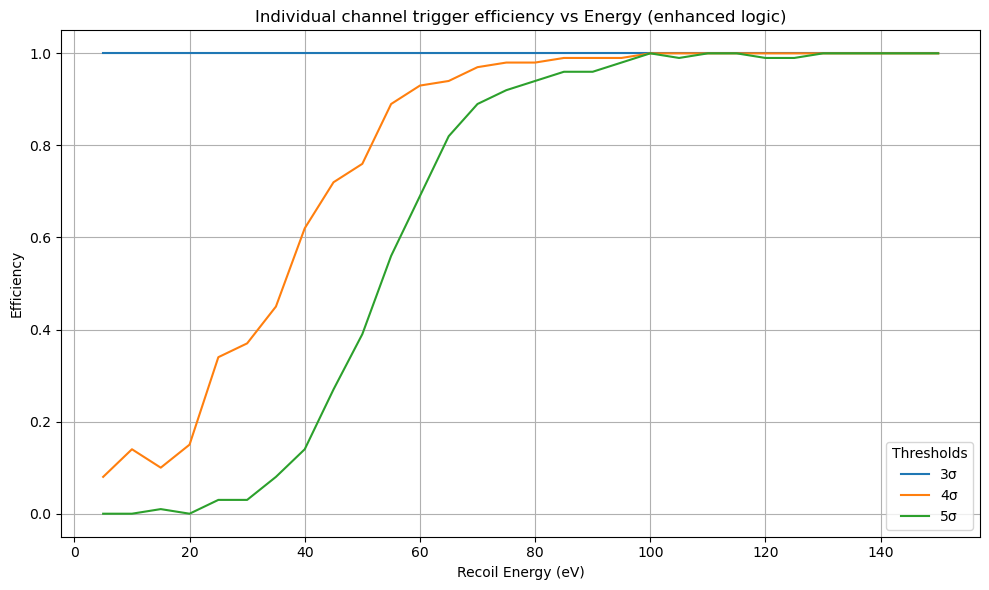

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

n_sets = 100
sigma = 0.7674  # sigma for the fixed OF ampl distribution with MMC noise traces
thresholds = [round(n * sigma, 4) for n in [3, 4, 5]]
energy_values = list(range(5, 151, 5))
pass_rates_by_threshold = {th: [] for th in thresholds}

for energy in tqdm(energy_values, desc="Processing energies"):
    trace_path = f"/ceph/dwong/trigger_samples/traces_energy_{energy}.zst"
    loaded_traces = load_traces_from_zstd(trace_path, n_traces=n_sets)  # shape: (n_sets, 54, trace_length)

    effective_amplitudes = []

    for i in range(n_sets):
        results = [trigger.fit_with_shift(trace) for trace in loaded_traces[i]]
        amps = np.array([res[0] for res in results])
        t0s = np.array([res[2] for res in results])  # t₀ is the third value

        top2_indices = np.argsort(amps)[-2:][::-1]  # Indices of top 2 amplitudes
        a1, t1 = amps[top2_indices[0]], t0s[top2_indices[0]]
        a2, t2 = amps[top2_indices[1]], t0s[top2_indices[1]]

        if abs(t1 - t2) < 100:
            effective_amplitude = a1 + a2
        else:
            effective_amplitude = a1

        effective_amplitudes.append(effective_amplitude)


    effective_amplitudes = np.array(effective_amplitudes)

    for th in thresholds:
        pass_rate = np.sum(effective_amplitudes > th) / n_sets
        pass_rates_by_threshold[th].append(pass_rate)

# Plotting
sigma_labels = {
    thresholds[0]: '3σ',
    thresholds[1]: '4σ',
    thresholds[2]: '5σ'
}

plt.figure(figsize=(10, 6))
for th in thresholds:
    plt.plot(energy_values, pass_rates_by_threshold[th], label=sigma_labels[th])

plt.xlabel('Recoil Energy (eV)')
plt.ylabel('Efficiency')
plt.title('Individual channel trigger efficiency vs Energy (enhanced logic)')
plt.legend(title='Thresholds')
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
import numpy as np
from tqdm import tqdm

# Parameters
energy = 100
set_idx_to_inspect = 2

# Load traces for 50 eV
trace_path = f"/ceph/dwong/trigger_samples/traces_energy_{energy}.zst"
loaded_traces = load_traces_from_zstd(trace_path, n_traces=100)

# Extract traces for set 1
traces_set1 = loaded_traces[set_idx_to_inspect]

# Compute (amplitude, chi2, t0) for each of the 54 traces
results = []
for trace_idx, trace in enumerate(traces_set1):
    amplitude, chi2, t0 = trigger.fit_with_shift(trace)
    results.append((trace_idx, amplitude, chi2, t0))

# Sort by amplitude descending
results.sort(key=lambda x: x[1], reverse=True)

# Print the results
print(f"Energy: {energy} eV | Set: {set_idx_to_inspect}")
print("Trace Index | Amplitude | Chi2 | t0")
for trace_idx, amplitude, chi2, t0 in results:
    print(f"{trace_idx:11d} | {amplitude:9.4f} | {chi2:5.4f} | {t0:5.2f}")


Energy: 100 eV | Set: 2
Trace Index | Amplitude | Chi2 | t0
         46 |    5.9803 | 0.2284 | 2094.00
         53 |    3.3725 | 0.2198 | 1823.00
         45 |    3.2181 | 0.2183 | -565.00
          7 |    2.7261 | 0.2177 | 15078.00
         31 |    2.6622 | 0.2176 | -6004.00
         29 |    2.6078 | 0.2177 | -10281.00
          8 |    2.5579 | 0.2174 | 2758.00
         13 |    2.4812 | 0.2172 | -13878.00
         37 |    2.4569 | 0.2177 | 264.00
         34 |    2.4274 | 0.2174 | -2097.00
         26 |    2.4025 | 0.2177 | -14598.00
          2 |    2.3675 | 0.2178 | -1367.00
         38 |    2.3188 | 0.2174 | -5072.00
         14 |    2.2907 | 0.2177 | 2686.00
         51 |    2.2713 | 0.2177 | 11483.00
         23 |    2.2588 | 0.2174 | 6207.00
         28 |    2.2476 | 0.2179 | 3058.00
         35 |    2.2339 | 0.2177 | 6622.00
          3 |    2.1374 | 0.2176 | 12278.00
         25 |    2.1139 | 0.2174 | -16008.00
          1 |    2.1133 | 0.2172 | 14736.00
         41 |    2.091

Loading noise traces (0 eV)...


Processing noise sets: 100%|██████████| 1000/1000 [01:26<00:00, 11.58it/s]



Loading signal traces (25 eV)...


Processing 25 eV signal sets: 100%|██████████| 100/100 [00:04<00:00, 23.69it/s]



Loading signal traces (50 eV)...


Processing 50 eV signal sets: 100%|██████████| 100/100 [00:03<00:00, 26.83it/s]



Loading signal traces (75 eV)...


Processing 75 eV signal sets: 100%|██████████| 100/100 [00:04<00:00, 23.74it/s]



Loading signal traces (100 eV)...


Processing 100 eV signal sets: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


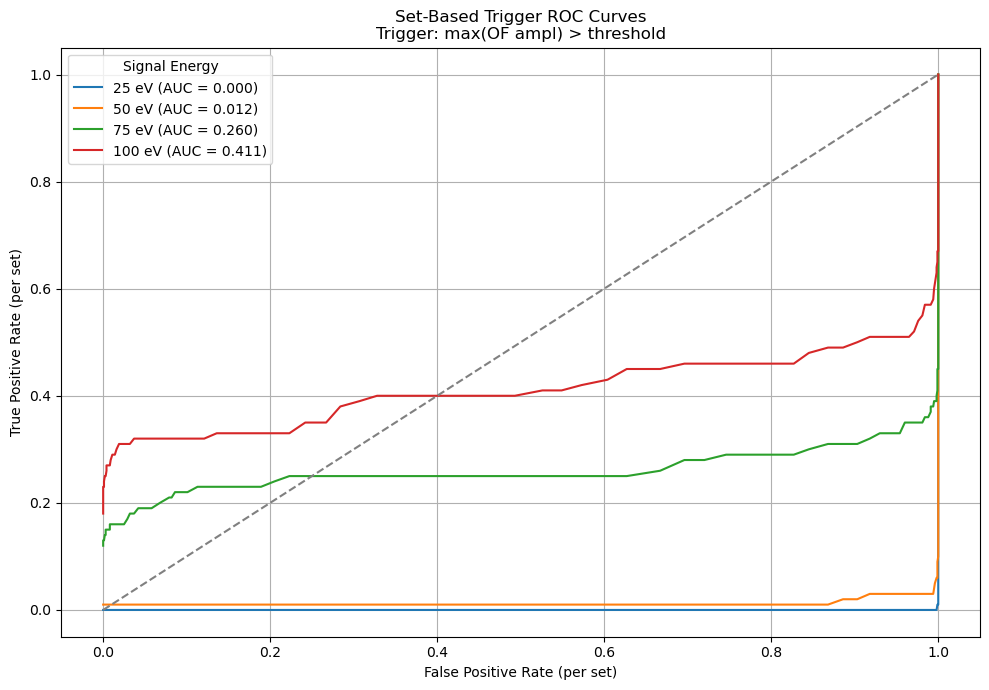

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from tqdm import tqdm

# Parameters
signal_energies = [25, 50, 75, 100]  # eV
n_noise_sets = 1000
n_signal_sets = 100
traces_per_set = 54

# --- Load noise (0 eV) once ---
print("Loading noise traces (0 eV)...")
noise_traces = load_traces_from_zstd("/ceph/dwong/trigger_samples/traces_energy_0.zst", n_traces=n_noise_sets)
noise_max_amplitudes = []
for traces in tqdm(noise_traces, desc="Processing noise sets"):
    amps = [trigger.fit_with_shift(trace)[0] for trace in traces]
    noise_max_amplitudes.append(np.max(amps))
noise_max_amplitudes = np.array(noise_max_amplitudes)

# --- Prepare threshold sweep ---
thresholds = np.linspace(0, 6, 500)

plt.figure(figsize=(10, 7))

# --- Process each signal energy ---
for signal_energy in signal_energies:
    print(f"\nLoading signal traces ({signal_energy} eV)...")
    signal_traces = load_traces_from_zstd(f"/ceph/dwong/trigger_samples/traces_energy_{signal_energy}.zst", n_traces=n_signal_sets)
    signal_max_amplitudes = []
    for traces in tqdm(signal_traces, desc=f"Processing {signal_energy} eV signal sets"):
        amps = [trigger.fit(trace)[0] for trace in traces]
        signal_max_amplitudes.append(np.max(amps))
    signal_max_amplitudes = np.array(signal_max_amplitudes)

    # Compute ROC
    tpr = []
    fpr = []
    for th in thresholds:
        tpr.append(np.sum(signal_max_amplitudes > th) / n_signal_sets)
        fpr.append(np.sum(noise_max_amplitudes > th) / n_noise_sets)

    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{signal_energy} eV (AUC = {roc_auc:.3f})")

# Finalize plot
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate (per set)')
plt.ylabel('True Positive Rate (per set)')
plt.title('Set-Based Trigger ROC Curves\nTrigger: max(OF ampl) > threshold')
plt.legend(title='Signal Energy')
plt.grid(True)
plt.tight_layout()
plt.show()
